In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np


from spyglass.common import Session
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")


from Analysis.utils import filter_opto_data, smooth
from ms_opto_stim_protocol import OptoStimProtocol
# from AnalysisTables import OptoStimTable
os.curdir

from AnalysisTables.decoding_tables import (
    ContinuousRippleTraversal,
    ContinuousRippleTraversalSelection,
    ContinuousRippleTraversalParams,
)



[2025-06-24 15:55:32,811][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-06-24 15:55:32,851][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306
[15:55:39][INFO] Spyglass: Initializing UserEnvironment for spikesorting: sambray_spyglass2025_02


# Populate

In [4]:
from AnalysisTables.decoding_tables import (
    ContinuousRippleTraversal,
    ContinuousRippleTraversalSelection,
    ContinuousRippleTraversalParams,
)
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.ripple.v1 import RippleTimesV1
from spyglass.position.position_merge import PositionOutput

params = {
    "ripple_traversal_params_name": "default acausal",
    "continuous_distance_threshold": 3,
    "acausal": True,
}
ContinuousRippleTraversalParams().insert1(params, skip_duplicates=True)
ContinuousRippleTraversalParams()

*ripple_traver continuous_dis acausal    
+------------+ +------------+ +---------+
default acausa 3.0            1          
 (Total: 1)

In [ ]:
from Analysis.utils import filter_opto_data

artifact_detection = "ms_lfp_artifact_times"
dataset_key = {"track_type": "early_wtrack"}
dataset = filter_opto_data(dataset_key)
dataset = dataset - "nwb_file_name LIKE 'banner%'"
pos_key = (PositionOutput.DLCPosV1()).proj(pos_merge_id="merge_id")
for key in dataset.fetch("KEY"):
    clusterless_query = ClusterlessDecodingV1() & {
        "nwb_file_name": key["nwb_file_name"],
        "position_group_name": "DLC " + key["interval_list_name"],
        "encoding_interval": key["interval_list_name"],
    }
    if not clusterless_query:
        continue
        # raise ValueError("No clusterless decoding found")
    clusterless_key = clusterless_query.fetch1("KEY")
    clusterless_key
    ripple_key = {
        "nwb_file_name": key["nwb_file_name"],
    }
    ripple_query = (
        RippleTimesV1
        & ripple_key
        # & f"target_interval_list_name LIKE '%{key['interval_list_name']}%'"
        & f"target_interval_list_name LIKE '%{key['interval_list_name']}_{artifact_detection}%'"
        & pos_key
    )
    if not ripple_query:
        continue
        raise ValueError("No ripples found")
    ripple_key = ripple_query.fetch1("KEY")

    insert_key = {
        **ripple_key,
        **clusterless_key,
        "ripple_traversal_params_name": "default acausal",
    }
    ContinuousRippleTraversalSelection().insert1(insert_key, skip_duplicates=True)

    ContinuousRippleTraversalSelection()
ContinuousRippleTraversal().populate(processes=32)

datasets: 86


[2025-03-27 15:27:56,838][WARNING]: Skipped checksum for file with hash: c10048af-56e5-a06a-f9d7-317c69fad593, and path: /stelmo/nwb/analysis/Olive20220711/Olive20220711_3b3621b5-8da9-44d0-9af2-c48c44abc34a.nc
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear more than once in dims=('states', 'states'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/xarray/namedarray/core.py:496: UserWarning: Duplicate dimension names present: dimensions {'states'} appear

{'success_count': 68, 'error_list': []}

# Results


(0.0, 100.0)

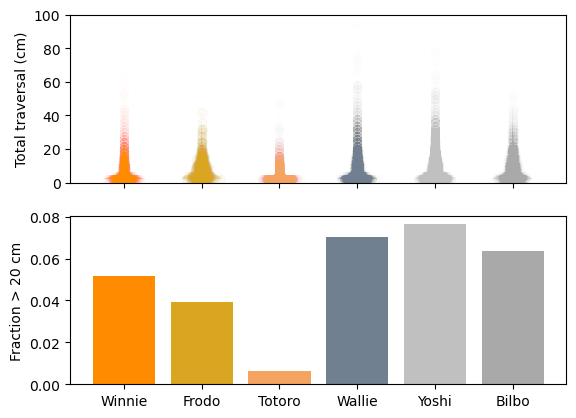

In [ ]:
from Style.style_guide import animal_style
from Analysis.utils import violin_scatter

i = 0
long_thresh = 20  # in cm

data = "longest"


fig, ax = plt.subplots(nrows=2, sharex=True)
animal_list = ["Winnie", "Frodo", "Totoro", "Wallie", "Yoshi", "Bilbo"]
for i, animal in enumerate(animal_list):
    query = (
        ContinuousRippleTraversal()
        & f"nwb_file_name LIKE '{animal}%'"
        & f"target_interval_list_name LIKE '%{artifact_detection}'"
    )
    if not query:
        continue
    df = query.fetch_dataframe()
    if data == "total":
        val = df.total_traversal
    elif data == "longest":
        val = df.longest_traversal * 2  # (puts it in cm)
    else:
        raise ValueError("Data type not recognized")
    violin_scatter(val, color=animal_style.loc[animal, "color"], pos=i, ax=ax[0])

    fract = val > long_thresh

    ax[1].bar(i, fract.mean(), color=animal_style.loc[animal, "color"])

ax[0].set_ylabel("Total traversal (cm)")
ax[1].set_ylabel(f"Fraction > {long_thresh} cm")


ax[1].set_xticks(np.arange(i + 1))
ax[1].set_xticklabels(animal_list)
ax[0].set_ylim(0, 100)

# Plotting exemplar long traces


In [ ]:
# Find good long continuous one
animal = "Totoro"
animal = "Winnie"
# animal = "Yoshi"
animal = "Wallie"

query_key = f"nwb_file_name LIKE '{animal}%'"

query_key = dict(nwb_file_name="Totoro20220613_.nwb", pos_interval="pos 1 valid times")
query = ContinuousRippleTraversal() & query_key

longest_key = None
max_length = 0

for key in query.fetch("KEY"):
    df = (query & key).fetch1_dataframe()
    if df.longest_traversal.max() > max_length:
        max_length = df.longest_traversal.max()
        longest_key = key

query & longest_key
traversal_df = (query & longest_key).fetch1_dataframe()

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.2.0 because version 0.2.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/s

In [3]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

nwb_file_name = longest_key["nwb_file_name"]
interval = longest_key["position_group_name"].strip("DLC ")
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
mua = mua / np.mean(np.diff(pos_df.index.values))
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'ndx-franklab-novela' version 0.1.0 because version 0.2.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/Documents/spyglass/src/spyglass/decoding/v1/core.py:308: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, 

In [8]:
from spyglass.lfp.analysis.v1.lfp_band import LFPBandV1
from spyglass.lfp.v1 import LFPV1
from spyglass.lfp.lfp_merge import LFPOutput
from spyglass.ripple.v1 import RippleTimesV1, RippleLFPSelection

LFPV1 & {"nwb_file_name": nwb_file_name, "target_interval_list_name": interval}
artifact_detection = "ms_lfp_artifact_times"
band_query = (
    LFPBandV1()
    & {
        "nwb_file_name": nwb_file_name,
        #    "target_interval_list_name": interval,
        "filter_name": "Ripple 150-250 Hz",
    }
    & "target_interval_list_name LIKE '%{}%'".format(interval)
    & f"target_interval_list_name LIKE '%{artifact_detection}%'"
)

# ripple_band_df = (LFPOutput() & band_query.proj(merge_id="lfp_merge_id")).fetch1_dataframe()

band_query
ripple_band_df = band_query.fetch1_dataframe()

In [44]:
# ripple_query = (
#     RippleLFPSelection.RippleLFPElectrode()
#     & band_query.proj()
#     & ContinuousRippleTraversal().proj()
# )
# ripple_query

In [51]:
state_posterior = results.acausal_posterior.unstack("state_bins").sum("position")[0]
state_posterior.shape

(632745, 2)

In [ ]:
traversal_df
from ms_opto_stim_protocol import OptoStimProtocol

longest_key
test_intervals = (
    OptoStimProtocol
    & longest_key
    & {"interval_list_name": longest_key["decoding_interval"]}
).fetch1("test_intervals")

first_test_interval = np.array([test_intervals[0]])

from spyglass.common import interval_list_contains_ind

ind_ripples = interval_list_contains_ind(
    first_test_interval, traversal_df["start_time"].values
)
traversal_df = traversal_df.iloc[ind_ripples]

[16:19:44][WARNING] Spyglass: DEPRECATION scheduled for Spyglass 0.6.0: interval_list_contains_ind
	Use Interval.contains instead


In [ ]:
ripple_num = np.argsort(traversal_df.longest_traversal.values)
print(ripple_num)
# Winnie
# ripple_num = ripple_num[-3]
# ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-5]
# Wallie
# ripple_num = ripple_num[-3]
# ripple_num = 294
# Yoshi
# ripple_num = ripple_num[-1]
# ripple_num = ripple_num[-2]
# ripple_num = ripple_num[-3]


ripple_num = ripple_num[-7]
# print(traversal_df.iloc[ripple_num])
st = traversal_df.iloc[ripple_num].start_time
en = traversal_df.iloc[ripple_num].end_time
# traversal_df.iloc[ripple_num]
# longest_key

[  0   1   2  11 105 106  95  96  98  87  90  21  22  24  78  79  80  73
  63  64  65  66  27  28  33  52  43  49  35  37   3   4   5 107 108 110
 111 112 114  18  41  44  42  45  46  48  47 101  94  93  56  55  54  53
  51  62  32  59  67  58  57  31  88  19  20  74  72  71  70  69  68  17
  12  13  14  38  36  39  40  15  86  23  26  10   9   8  89   6  91  16
  77  97  92  34  30  82  84  60  61 104 100 113  83  76  99  29  85 102
  50  25  81   7  75 109 103]
start_time           1.655152e+09
end_time             1.655152e+09
total_traversal      7.861651e+00
longest_traversal    8.000000e+00
Name: 50, dtype: float64


{'lfp_merge_id': UUID('8f3ec2e4-c512-6871-df6d-a53db604501f'),
 'filter_name': 'Ripple 150-250 Hz',
 'filter_sampling_rate': 1000,
 'nwb_file_name': 'Totoro20220613_.nwb',
 'target_interval_list_name': 'pos 1 valid times_ms_lfp_artifact_times',
 'lfp_band_sampling_rate': 1000,
 'group_name': 'CA1',
 'ripple_param_name': 'default_ms',
 'pos_merge_id': UUID('34402b5f-487a-226f-550d-f3440ad34e3c'),
 'waveform_features_group_name': '02_wtrack',
 'position_group_name': 'DLC pos 1 valid times',
 'decoding_param_name': 'ms_wtrack_contfrag_clusterless_causal',
 'encoding_interval': 'pos 1 valid times',
 'decoding_interval': 'pos 1 valid times',
 'estimate_decoding_params': 0,
 'ripple_traversal_params_name': 'default acausal'}

[87171 87172 87173 87174 87175 87176 87177 87178 87179 87180 87181 87182
 87183 87184 87185 87186 87187 87188 87189 87190 87191 87192 87193 87194
 87195 87196 87197 87198 87199 87200 87201 87202 87203 87204 87205 87206
 87207 87208 87209 87210 87211 87212 87213 87214 87215 87216 87217 87218
 87219 87220 87221 87222 87223 87224 87225 87226 87227 87228 87229 87230
 87231 87232 87233 87234 87235 87236 87237 87238 87239 87240 87241 87242
 87243 87244 87245 87246 87247 87248 87249 87250 87251 87252 87253 87254
 87255 87256 87257 87258 87259 87260 87261 87262 87263 87264 87265 87266
 87267 87268 87269 87270 87271 87272 87273 87274 87275 87276 87277 87278
 87279 87280 87281 87282 87283 87284 87285 87286 87287 87288 87289 87290
 87291 87292 87293 87294 87295 87296 87297 87298 87299 87300 87301 87302
 87303 87304 87305 87306 87307 87308 87309 87310 87311 87312 87313 87314
 87315 87316 87317 87318 87319 87320 87321 87322 87323 87324 87325 87326
 87327 87328 87329 87330 87331 87332 87333 87334 87

FileNotFoundError: [Errno 2] No such file or directory: '/home/sambray/Documents/MS_analysis_samsplaying/Plots/Figures_june2025/ripple_examples/post_control_Totoro20220613_.nwb_pos 1 valid times_ripple_50_rasterized.svg'

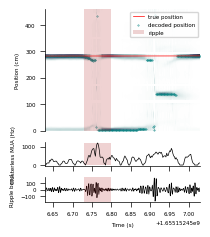

In [ ]:
# pos_df
posterior.shape, pos_df.shape

# t0 = pos_df.index.values[0] - 9 * 60 + 30.4
t0 = 0

t_rng = (st - 0.1, st + 0.3)
# t_rng = (st - 0.1, st + 0.5)

plt.rcParams.update({"font.size": 4})
lw = 0.5
plt.rcParams.update({"lines.linewidth": lw})
plt.rcParams.update({"axes.linewidth": lw})
plt.rcParams["xtick.major.width"] = lw  # Width of major x-ticks
plt.rcParams["ytick.major.width"] = lw
fig, ax = plt.subplots(
    nrows=3, figsize=(2, 2.5), sharex=False, height_ratios=[20, 4, 4]
)
# ax = [ax]
ind = np.where(
    (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
)[0]

ind

print(ind)
# ax[0].imshow(
#     posterior[ind].T,
#     aspect=0.0005,
#     extent=[*t_rng, results.position.max() + results.position.min() + 0, 0],
#     cmap="bone_r",
#     clim=[0, 0.05],
#     zorder=-1,
# )
t_plot = pos_df.index[ind].values  # - t0
xx, yy = np.meshgrid(t_plot, results.position)
pos_val = results.position.values
pos_val = pos_val[: pos_val.shape[0] // 2]
XX, YY = np.meshgrid(t_plot, pos_val)
clim = None
ax[0].pcolormesh(
    XX,
    YY,
    posterior[ind].T,
    cmap="bone_r",
    shading="nearest",
    clim=clim,
    rasterized=True,
)
# ax[0].scatter(t_plot, linear_pos[ind], color="r", s=.15)

ax[0].plot(t_plot, linear_pos[ind], "r", label="true position")
ax[0].scatter(t_plot, decode_pos[ind], color="teal", s=0.1, label="decoded position")


ax[1].plot(t_plot, mua[ind], "k")

# ripples
ind_ripple = np.where(
    np.logical_and(
        (ripple_band_df.index.values >= t0 + t_rng[0]),
        (ripple_band_df.index.values < t0 + t_rng[1]),
    )
)[0]
t_rip = ripple_band_df.index[ind_ripple]
y_rip = ripple_band_df.iloc[ind_ripple].values[:, 2].astype(float)
gaps = np.where(np.diff(t_rip) > 0.01)[0] + 1
y_rip[gaps] = 1.0 * np.nan
ax[2].plot(t_rip, y_rip, "k")
ax[2].set_ylabel("Ripple band")
rip_lo = np.nanmin(y_rip) * 1.05
rip_hi = np.nanmax(y_rip) * 1.05
ax[2].fill_between(
    [st, en], rip_lo, rip_hi, facecolor="firebrick", alpha=0.2, zorder=10
)
ax[2].set_ylim(rip_lo, rip_hi)


ax[0].fill_between(
    [st, en],
    0,
    np.nanmax(linear_pos),
    facecolor="firebrick",
    alpha=0.2,
    zorder=10,
    label="ripple",
)
ax[1].fill_between(
    [st, en], 0, np.nanmax(mua[ind]), facecolor="firebrick", alpha=0.2, zorder=0
)

ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
# ax[0].set_title(f"{nwb_file_name}, {interval}, ripple {ripple_num}")
ax[1].set_ylabel("Clusterless MUA (Hz)")
ax[0].legend()

for a in ax:
    a.spines[["top", "right"]].set_visible(False)
    a.set_xlim(t_rng)
ax[0].spines[["bottom"]].set_visible(False)
ax[0].set_xticks([])
# ax[0].set_ylim(0, 100)
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(
#     f"Figures_20241201/ripple_examples/{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
# )
# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/ripple_examples/{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
# )

# fig.savefig(
#     f"/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/ripple_examples/pre_control_{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
# )
fig.savefig(
    f"/home/sambray/Documents/MS_analysis_samsplaying/Plots/Figures_june2025/pre_control_{nwb_file_name}_{interval}_ripple_{ripple_num}_rasterized.svg"
)

In [ ]:
(traversal_df.iloc[ripple_num].start_time - first_test_interval[0][0]) / 60

1.2413055380185445

In [20]:
import os

os.listdir("/home/sambray/Documents/MS_analysis_samsplaying/Figures_20250210/")

['stim_field_interact_linear_theta90.svg',
 'lineartrack_theta90_phase_histogram.svg',
 "kl_change_placeField_stimOn_{'animal': 'control', 'track_type': 'lineartrack', 'targeted_phase': 90, 'laser_power': 77}.svg",
 'wtrack_examples_Winnie20220719_pos 3 valid times_index41250_acausal_rasterized.svg',
 'ripple_content.svg',
 'wtrack_decode_stim_response_all_aheadBehind_noClip.svg',
 'wtrack_examples_Winnie20220719_pos 3 valid times_index14501_acausal_rasterized.svg',
 'wtrack_examples_Frodo20230814_pos 15 valid times_index155501_acausal_rasterized.svg',
 'wtrack_decode_stim_response_all_aheadBehind_Clip.svg',
 'decode_error_pooled.svg',
 'wtrack_examples_Frodo20230814_pos 15 valid times_index34501_acausal_rasterized.svg',
 'wtrack_examples_Yoshi20220517_pos 5 valid times_index269501_acausal_rasterized.svg',
 'wtrack_examples_Wallie20220922_pos 3 valid times_index60100_acausal_rasterized.svg',
 'wtrack_examples_Winnie20220719_pos 3 valid times_index485596_acausal_rasterized.svg',
 'wtrac

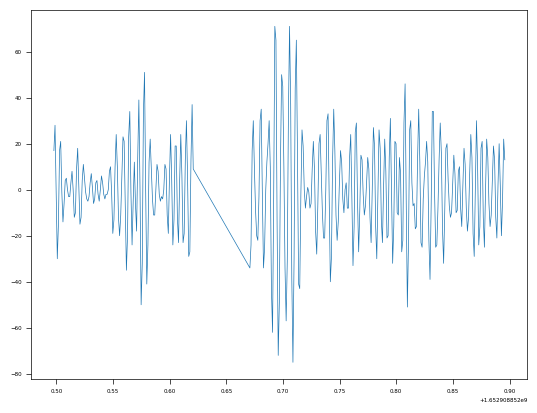

In [65]:
i = 4
plt.plot(ripple_band_df.index[ind_ripple], ripple_band_df[i].iloc[ind_ripple])

# Control Animal

In [36]:
ClusterlessDecodingV1 & {
    "nwb_file_name": "Winnie20220719_.nwb",
}

*nwb_file_name *waveform_feat *position_grou *decoding_para *encoding_inte *decoding_inte *estimate_deco results_pa classifier
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +--------+ +--------+
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 02_wtrack      DLC pos 1 vali ms_wtrack_cont pos 1 valid ti pos 1 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 04_wtrack      DLC pos 3 vali ms_wtrack_cont pos 3 valid ti pos 3 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
Winnie20220719 06_wtrack      DLC pos 5 vali ms_wtrack_cont pos 5 valid ti pos 5 valid ti 0              =BLOB=     =BLOB=    
   ...
 (Total: 36)

In [ ]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

interval = "pos 1 valid times"
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": "Yoshi20220518_.nwb",
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

KeyboardInterrupt: 

In [ ]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"
# classifier = (Decoder & key).fetch_model()
# classifier.encoding_model_
# for encoding_model in classifier.encoding_model_:
#     place_fields = np.asarray(
#         classifier.encoding_model_[encoding_model]["place_fields"]
#     )
#     norm_place = place_fields / np.mean(place_fields, axis=1)[:, None]
#     ind_plot = np.where(norm_place.max(axis=1) > 1.5)[0]
# # place_fields = np.asarray(
# #     classifier.encoding_model_[encoding_model]["place_fields"]
# # )
# neuron_sort_ind = np.argsort(np.nanargmax(place_fields, axis=1).squeeze())
# neuron_sort_ind = [x for x in neuron_sort_ind if x in ind_plot]

[254701 254702 254703 ... 258698 258699 258700]


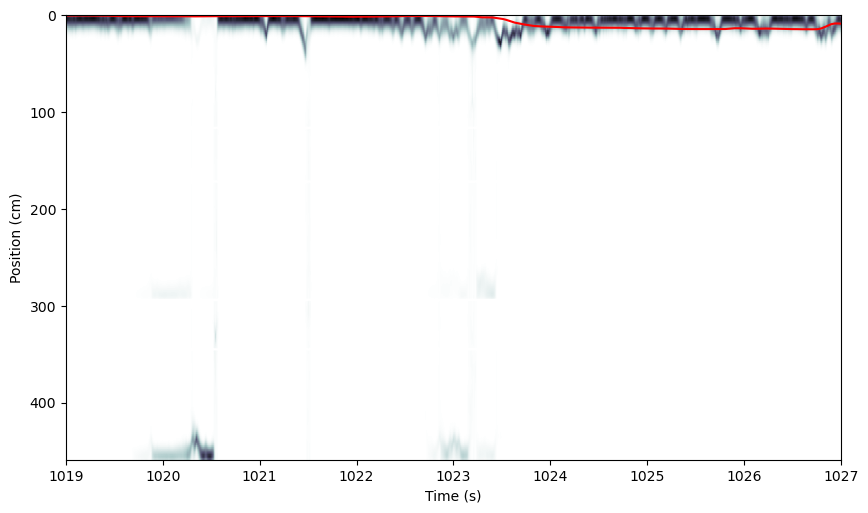

In [ ]:
# pos_df
posterior.shape, pos_df.shape

t0 = pos_df.index.values[0] - 9 * 60 + 30.4


st = 16 * 60 + 2 - 20
t_rng = (st, st + 50)

st = 17 * 60 + 2 - 3
t_rng = (st, st + 8)


# st=280.6
# t_rng=(st,281.7)
# st = 504 #- 19
# t_rng = (st, st+3)


# fig = plt.figure(figsize=(10,10))
fig, ax = plt.subplots(nrows=1, figsize=(10, 10), sharex=True)
ax = [ax]
ind = np.where(
    (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
)[0]
print(ind)
ax[0].imshow(
    posterior[ind].T,
    aspect=0.01,
    extent=[*t_rng, np.nanmax(linear_pos), 0],
    cmap="bone_r",
)
ax[0].plot(pos_df.index[ind].values - t0, linear_pos[ind], "r")
# ax[0].plot(pos_df.index[ind].values - t0, decode_pos[ind], "teal")


stim_ind = np.where((stim_time >= t0 + t_rng[0]) & (stim_time < t0 + t_rng[1]))[0]
for i in range(len(stim_ind)):
    if i == 0 and stim[stim_ind[i]] == 0:
        ax[0].fill_betweenx(
            [0, linear_pos.max()],
            t0,
            stim_time[stim_ind[i]] - t0,
            color="thistle",
            alpha=0.5,
        )
    elif stim[stim_ind[i]] == 1:
        ax[0].fill_betweenx(
            [0, linear_pos.max()],
            stim_time[stim_ind[i]] - t0,
            stim_time[stim_ind[i + 1]] - t0,
            color="thistle",
            alpha=0.5,
        )


ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
# ax[0].set_title(dataset_key)


j = 0
# for ii, s_ind in enumerate(neuron_sort_ind[::]):
#     spike_times = spikes[s_ind]

#     marks = (
#         spike_times[
#             np.logical_and(spike_times >= t0 + t_rng[0], spike_times < t0 + t_rng[1])
#         ]
#         - t0
#     )
#     if marks.size < 3 or marks.size > 50:
#         continue
#     ax[1].vlines(marks, j, j + 0.8, color="k")
#     j -= 1

# for i in range(len(stim_ind)):
#     if i == 0 and stim[stim_ind[i]] == 0:
#         ax[1].fill_betweenx(
#             [1, j + 1], t0, stim_time[stim_ind[i]] - t0, color="thistle", alpha=0.5
#         )
#     elif stim[stim_ind[i]] == 1:
#         ax[1].fill_betweenx(
#             [1, j + 1],
#             stim_time[stim_ind[i]] - t0,
#             stim_time[stim_ind[i + 1]] - t0,
#             color="thistle",
#             alpha=0.5,
#         )
# ax[1].set_ylabel("Unit")
# ax[1].set_ylim(j + 1, 1)

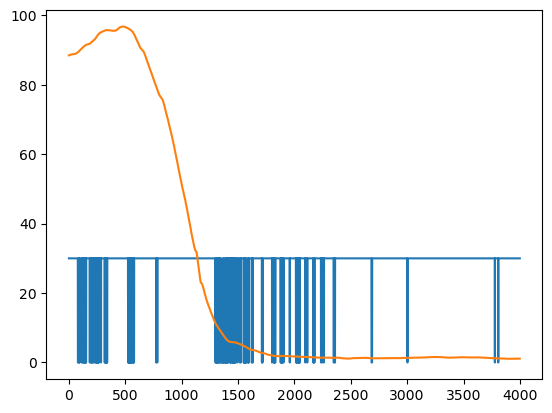

In [ ]:
ind = slice(6000, 10000)

plt.plot((np.abs(np.diff(decode_pos)) < 3).astype(int)[ind] * 30)


# plt.plot(np.abs(np.diff(decode_pos))[ind])
plt.plot(linear_pos[ind])

In [ ]:
from spyglass.ripple.v1 import RippleTimesV1
from spyglass.position.position_merge import PositionOutput

pos_table = PositionOutput.DLCPosV1().proj(pos_merge_id="merge_id")
ripple_query = (
    RippleTimesV1()
    & opto_key
    & f"target_interval_list_name LIKE '%{interval}%'"
    & pos_table
)
ripple_df = ripple_query.fetch1_dataframe()

In [ ]:
all_traversals = []
all_longest_traversals = []
for i, (st, en) in enumerate(zip(ripple_df.start_time, ripple_df.end_time)):
    # plt.axvspan(st, en, color="red", alpha=0.5)

    ind_st, ind_end = np.digitize([st, en], results.time)
    decode_pos_ripple = np.argmax(posterior[ind_st:ind_end].values, axis=1)
    distances = np.array(
        [
            distance_dict[x][y]
            for x, y in zip(decode_pos_ripple[:-1], decode_pos_ripple[1:])
        ]
    )
    continuous_decode = distances < 3
    total_valid_traversal = np.sum(continuous_decode * distances)
    total_valid_traversal
    all_traversals.append(total_valid_traversal)

    continuous_decode_switch = np.concatenate(
        [np.ones(1), np.diff(continuous_decode.astype(int))]
    )
    cont_st_list = np.where(continuous_decode_switch == 1)[0]
    cont_en_list = np.where(continuous_decode_switch == -1)[0]
    if len(cont_st_list) > len(cont_en_list):
        cont_en_list = np.concatenate([cont_en_list, [len(continuous_decode)]])
    continuous_valid_traversal = []
    for c_st, c_en in zip(cont_st_list, cont_en_list):
        # continuous_valid_traversal.append(np.sum(distances[c_st:c_en]*continuous_decode[c_st:c_en]))
        continuous_valid_traversal.append(np.unique(decode_pos_ripple[c_st:c_en]).size)
    longest_traversal = np.max(continuous_valid_traversal)
    all_longest_traversals.append(longest_traversal)
    # if total_valid_traversal >20:
    #     break
    # if longest_traversal >10:
    #     break

(array([129.,   0.,   0.,   0.,  87.,   0.,  22.,   0.,  28.,  17.,  14.,
         14.,  10.,   1.,   3.,   2.,   3.,   1.,   2.,   2.]),
 array([0.        , 0.07385606, 0.14771213, 0.22156819, 0.29542425,
        0.36928031, 0.44313638, 0.51699244, 0.5908485 , 0.66470456,
        0.73856063, 0.81241669, 0.88627275, 0.96012882, 1.03398488,
        1.10784094, 1.181697  , 1.25555307, 1.32940913, 1.40326519,
        1.47712125]),
 <BarContainer object of 20 artists>)

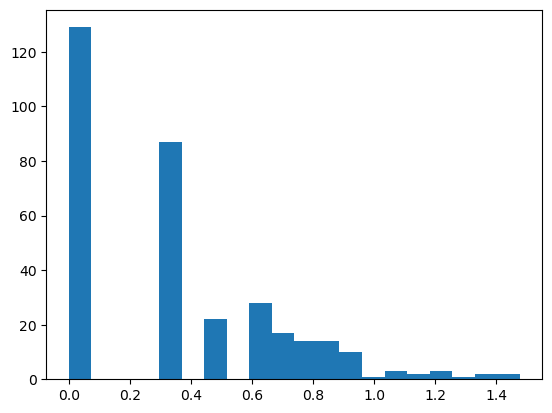

In [ ]:
# plt.hist(all_traversals,bins=20)
plt.hist(np.log10(all_longest_traversals), bins=20)

Text(0, 0.5, 'MUA')

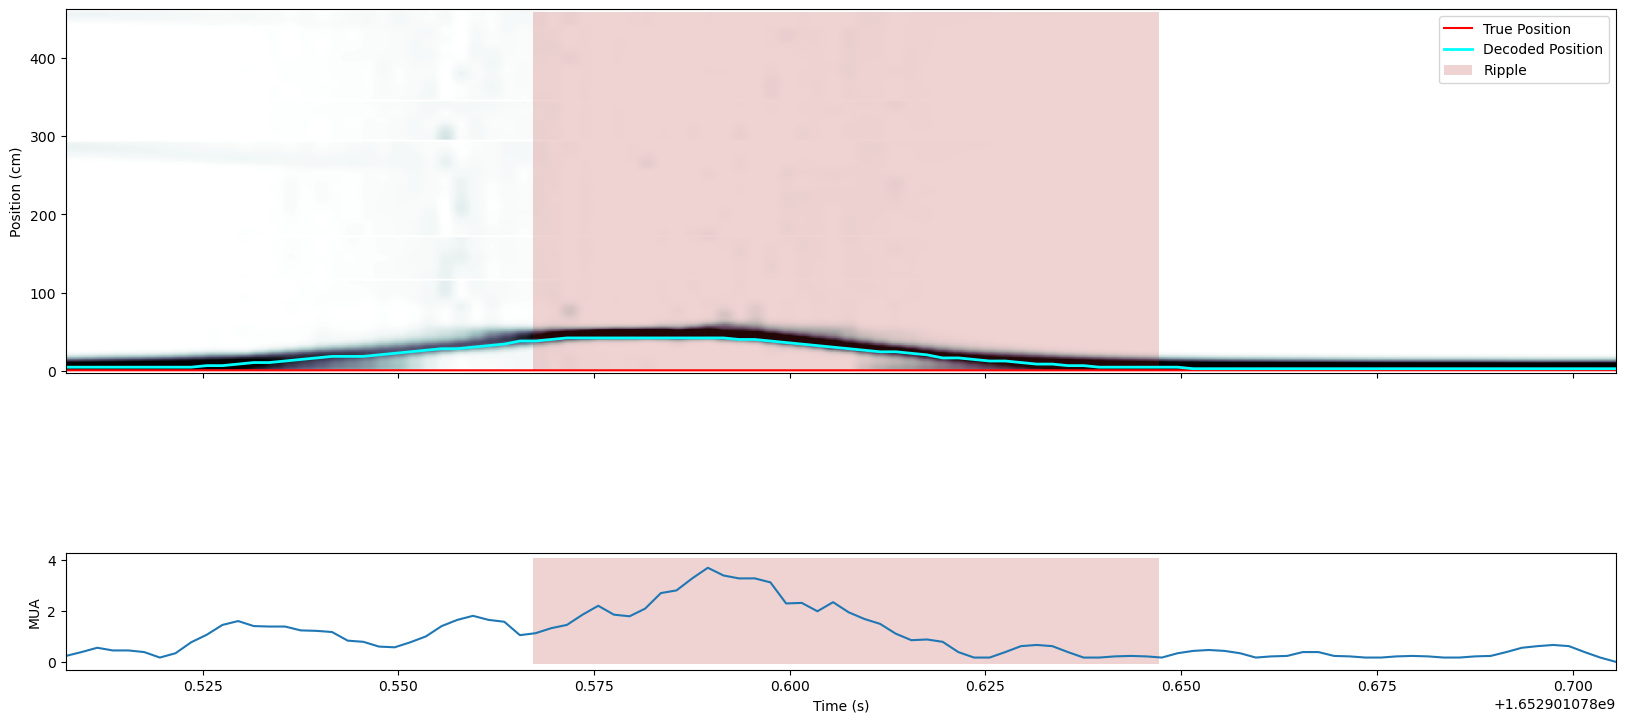

In [ ]:
plot_buffer = 30
fig, ax = plt.subplots(nrows=2, sharex=True, height_ratios=[5, 1], figsize=(20, 10))

t_plot = results.time[ind_st - plot_buffer : ind_end + plot_buffer].values
ax[0].imshow(
    posterior[ind_st - plot_buffer : ind_end + plot_buffer].T,
    clim=[0, 0.1],
    cmap="bone_r",
    aspect=1 / 10000,
    extent=[t_plot[0], t_plot[-1], np.nanmax(linear_pos), 0],
)
ax[0].plot(
    t_plot,
    linear_pos[ind_st - plot_buffer : ind_end + plot_buffer],
    "r",
    label="True Position",
)
ax[0].plot(
    t_plot,
    decode_pos[ind_st - plot_buffer : ind_end + plot_buffer],
    "cyan",
    lw=2,
    label="Decoded Position",
)
# plt.vlines(ripple_df.start_time[i],0,np.nanmax(linear_pos),color="red")
ax[0].fill_between(
    [ripple_df.start_time[i], ripple_df.end_time[i]],
    0,
    np.nanmax(linear_pos),
    facecolor="firebrick",
    alpha=0.2,
    label="Ripple",
)
ax[1].fill_between(
    [ripple_df.start_time[i], ripple_df.end_time[i]],
    -0.1,
    np.max(mua[ind_st:ind_end]) * 1.1,
    facecolor="firebrick",
    alpha=0.2,
)
ax[0].set_ylim(-3, np.nanmax(linear_pos) + 3)

ax[1].plot(t_plot, mua[ind_st - plot_buffer : ind_end + plot_buffer])

ax[0].legend()
ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
ax[1].set_ylabel("MUA")